In [1]:
import os
import numpy as np
import pickle as pc
import tensorflow as tf
from utils import *

#from seq2seq import *
from GRU import *

In [2]:
LBNL_DATA_DIR = 'data/LBNL Building 74/lbnlb74electricity.xlsx'
horizon_size = 96
best_loss = 100000000.0
lr = 0.0001
batch_size = 1
max_patience = 7
max_epochs = 100
checkpoint_dir = 'gru1_checkpoint'
LOG_INTERVAL = 200
keep_rate = 0.5
hidden_unit = 16

debug = False

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
def evaluate():
    # data load
    time, elec = load_data(LBNL_DATA_DIR)
    
    # modify
    elec = missing_value(elec)
    print(elec[40226])
    
    elec = std_normalize(elec)
    
    # split data
    train, valid, test = split_dataset(elec)
    
    # build dataset
    test_observe, test_pred = lstm_build_dataset(test, horizon_size)
    print("Build Dataset Finished")
    print("[Test] enc {}\tdec {}".format(len(test_observe), len(test_pred)))
    
    # model
    gru = GRU(hidden_unit, keep_rate)
    
    # optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    # loss & metric obj
    loss_obj = tf.keras.losses.MeanSquaredError()
    rmse_obj = tf.keras.metrics.RootMeanSquaredError()
  
    # ckpt dir
    #checkpoint = tf.train.Checkpoint(optimizer=optimizer,gru=gru)
    ckpt_dir = os.path.join(checkpoint_dir, 'best_lr-{}_hidden-{}_hr-{}'.format(lr, hidden_unit, horizon_size))
    latest_ckpt = tf.train.latest_checkpoint(ckpt_dir)
    #
    #latest_ckpt = os.path.join(ckpt_dir, 'best_ckpt_1')
    print("latest ckpt: {}".format(latest_ckpt))
#    checkpoint.restore(latest_ckpt)
    
    gru.load_weights(filepath=latest_ckpt)
    num_batches_per_epoch = (len(test_observe)-1) // batch_size + 1
    print("num_batches_per_epoch: {}".format(num_batches_per_epoch))
    
    test_batches = batch_iter(test_observe, test_pred, batch_size)

    test_loss = list()
    preds = list()
    trues = list()
    for batch_idx, (batch_x, batch_y) in enumerate(test_batches):
    
        logits = gru(batch_x, training=False)

        preds.extend(tf.reshape(logits, [-1]).numpy())
        trues.extend(tf.reshape(batch_y, [-1]).numpy())
        
        loss = loss_obj(batch_y, logits)

        rmse_obj.update_state(batch_y, logits)
        test_loss.append(np.mean(loss))
    
    print("true: {}\tpred: {}".format(len(trues), len(preds)))
    print("loss: {:.4f} RMSE: {:.4f}".format(np.mean(test_loss), rmse_obj.result().numpy()))
    rmse_obj.reset_states()

    return trues, preds

In [4]:
def show_plot(time_step, true, pred, title):
    import matplotlib as mpl
    import matplotlib.pylab as plt
    %matplotlib inline
    
    marker = ['.-', 'r-']
    
    plt.title(title)
    plt.figure(figsize=(30, 10))
    plt.plot(time_step[5000:5500], true[5000:5500], marker[0], label='True')
    plt.plot(time_step[5000:5500], pred[5000:5500], marker[1], label='Pred')
    plt.legend()
    plt.xlabel('Time-step')
    return plt

/usr/local/lib/python3.6/dist-packages/openpyxl/worksheet/_reader.py:292: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Size of time, elec: 46111	46111
43.899
Mean: 31.535117450933615	Std: 8.103161225783838
Size of train, valid, test: 27973	6994	11144
Build Dataset Finished
[Test] enc 11048	dec 11048


W1208 12:41:21.799494 139842949076800 base_layer.py:1772] Layer gru is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



latest ckpt: gru1_checkpoint/best_lr-0.0001_hidden-16_hr-96/best_ckpt_3
num_batches_per_epoch: 11048
true: 1060608	pred: 1060608
loss: 1.1494 RMSE: 1.0721


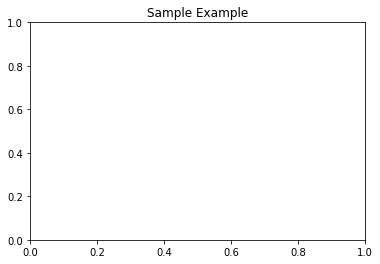

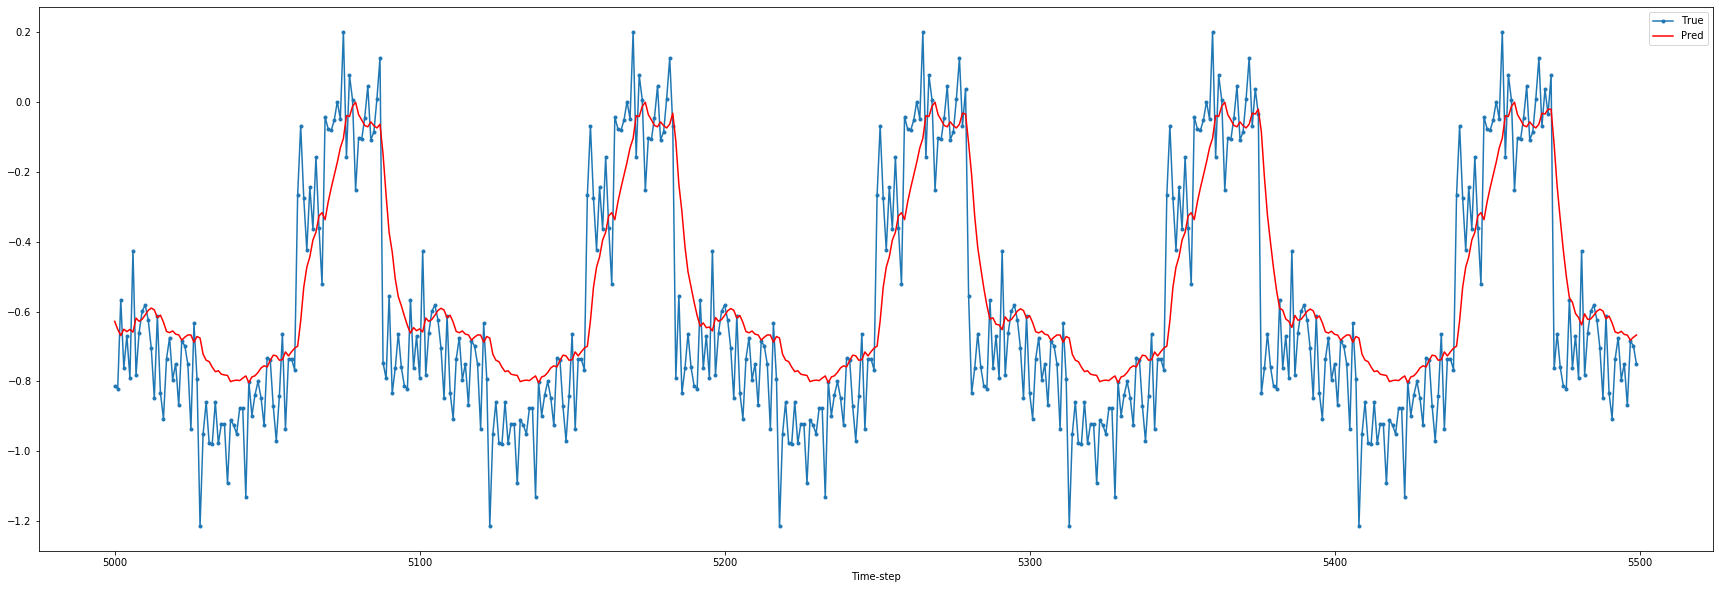

In [5]:
if __name__ == '__main__':
    true, pred = evaluate()
    
    time_step = list()
    for i in range(len(true)):
        time_step.append(i)
    with open('gru2_pred_{}_{}'.format(horizon_size, hidden_unit), 'wb') as f:
        pc.dump([time_step, true, pred], f)
        
    show_plot(time_step, true, pred, 'Sample Example')